In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# import argparse

import pandas as pd
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin,ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from liblinear.liblinearutil import train, problem, parameter
from liblinear.liblinearutil import predict as pred

from scipy.sparse import hstack
from sklearn.ensemble import VotingClassifier




In [2]:
df = pd.read_csv('../corpus/dataset.csv')
df['sentence']=df['sentence'].values.astype('U')
print(len(df))

X = df['sentence']
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, stratify=y, random_state=42)
df_test = pd.concat([X_test, y_test], axis=1)
df_2 = pd.concat([X_train, y_train], axis=1)


773034


In [3]:
class CustomModel(BaseEstimator, TransformerMixin,ClassifierMixin):
    def __init__(self, c_gram_range=(1, 1), C=1.0, w_gram_range=(1,1), s=2,  max_features=20000):
        self.c_gram_range = c_gram_range
        self.w_gram_range = w_gram_range
        self.s = s
        self.C = C
        self.max_features = max_features
        self.word_vectorizer=None
        self.m = None
        self.char_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=self.c_gram_range, lowercase=False,max_features= self.max_features )
        if w_gram_range:
            self.word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=self.w_gram_range, lowercase=False,max_features= self.max_features )
    def fit(self, X, y):
        # Tokenize and vectorize the input data

        self.classes_ = unique_labels(y)

        X_char_transformed = self.char_vectorizer.fit_transform(X)
        if self.word_vectorizer:
            X_word_transformed = self.word_vectorizer.fit_transform(X)
            X_train_combined = hstack([X_char_transformed, X_word_transformed])
            prob  = problem(y, X_train_combined)
        else:
            prob  = problem(y, X_char_transformed)


        self.m = train(prob, parameter(f'-s {self.s} -c {self.C}'))
        self.is_fitted_ = True
        return self

    def transform(self, X):
        # Tokenize and vectorize the input data
        check_is_fitted(self)
        X_char_transformed = self.char_vectorizer.transform(X)
        if self.word_vectorizer:
            X_word_transformed = self.word_vectorizer.fit_transform(X)
            X_train_combined = hstack([X_char_transformed, X_word_transformed])
            return X_train_combined
        else:
            return X_char_transformed

    def predict(self, X):
        # Tokenize and vectorize the input data, then make predictions
        check_is_fitted(self)

        # Input validation
        X_transformed = self.transform(X)
        p_label1, p_acc, p_val = pred([], X_transformed, self.m)
        return [int(x) for x in p_label1]

In [4]:
len(df_2)

772034

In [5]:
X = df_2['sentence']
y=df_2['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, train_size=100000, random_state=42)


In [6]:
custom_model1 = CustomModel(c_gram_range=(1, 4), C=1.0, w_gram_range=(1,3), s=2,  max_features=50000)
custom_model2 = CustomModel(c_gram_range=(1, 4), C=1.0, w_gram_range=(1,4), s=2,  max_features=20000)
custom_model3 = CustomModel(c_gram_range=(1, 4), C=1.0, w_gram_range=None, s=1,  max_features=None)
custom_model4 = CustomModel(c_gram_range=(1, 6), C=0.25, w_gram_range=None, s=2,  max_features=None)
custom_model5 = CustomModel(c_gram_range=(1, 6), C=0.5, w_gram_range=(1,3), s=1,  max_features=50000)
custom_model6 = CustomModel(c_gram_range=(1, 6), C=1.0, w_gram_range=(1,4), s=2,  max_features=20000)
custom_model7 = CustomModel(c_gram_range=(1, 8), C=5, w_gram_range=(1,3), s=2,  max_features=20000)
custom_model8 = CustomModel(c_gram_range=(1, 8), C=1.0, w_gram_range=(1,3), s=1,  max_features=20000)

# Create an ensemble model with custom models
ensemble_model = VotingClassifier(estimators=[
    ('custom_model1', custom_model1),
    ('custom_model2', custom_model2),
    ('custom_model3', custom_model3),
    ('custom_model4', custom_model4),
    ('custom_model5', custom_model5),
    ('custom_model6', custom_model6),
    ('custom_model7', custom_model7),
    ('custom_model8', custom_model8)
], voting='hard')

# Fit the ensemble model on the training data
ensemble_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = ensemble_model.predict(X_test)

# Evaluate the accuracy of the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print(f'Ensemble Model Accuracy: {accuracy}')

init f 1.000e+05 |g| 4.188e+04
iter  1 f 2.025e+04 |g| 4.549e+03 CG   2 step_size 1.00e+00 
iter  2 f 1.341e+04 |g| 1.555e+03 CG   3 step_size 1.00e+00 
iter  3 f 1.047e+04 |g| 4.272e+03 CG   9 step_size 1.00e+00 
iter  4 f 7.931e+03 |g| 5.660e+02 CG   2 step_size 1.00e+00 
iter  5 f 6.468e+03 |g| 3.978e+02 CG  13 step_size 1.00e+00 
iter  6 f 6.322e+03 |g| 1.030e+02 CG   4 step_size 1.00e+00 
iter  7 f 6.289e+03 |g| 1.847e+02 CG   4 step_size 1.00e+00 
iter  8 f 6.243e+03 |g| 3.442e+01 CG   3 step_size 1.00e+00 
init f 1.000e+05 |g| 4.118e+04
iter  1 f 1.794e+04 |g| 5.265e+03 CG   2 step_size 1.00e+00 
iter  2 f 7.691e+03 |g| 1.399e+03 CG   4 step_size 1.00e+00 
iter  3 f 4.801e+03 |g| 6.290e+02 CG   8 step_size 1.00e+00 
iter  4 f 4.432e+03 |g| 6.653e+02 CG  11 step_size 5.00e-01 
iter  5 f 4.064e+03 |g| 2.609e+02 CG   4 step_size 1.00e+00 
iter  6 f 4.051e+03 |g| 6.390e+02 CG  11 step_size 1.00e+00 
iter  7 f 3.791e+03 |g| 4.668e+01 CG   2 step_size 1.00e+00 
init f 1.000e+05 |g| 4.

In [7]:
y_pred = ensemble_model.predict(df_test['sentence'].values)


Accuracy = 1.5% (15/1000) (classification)
Accuracy = 1.8% (18/1000) (classification)
Accuracy = 1.5% (15/1000) (classification)
Accuracy = 1.5% (15/1000) (classification)
Accuracy = 1.2% (12/1000) (classification)
Accuracy = 2.1% (21/1000) (classification)
Accuracy = 2.5% (25/1000) (classification)
Accuracy = 2% (20/1000) (classification)


In [9]:
accuracy = accuracy_score(df_test['class'].values, y_pred)
accuracy

0.874

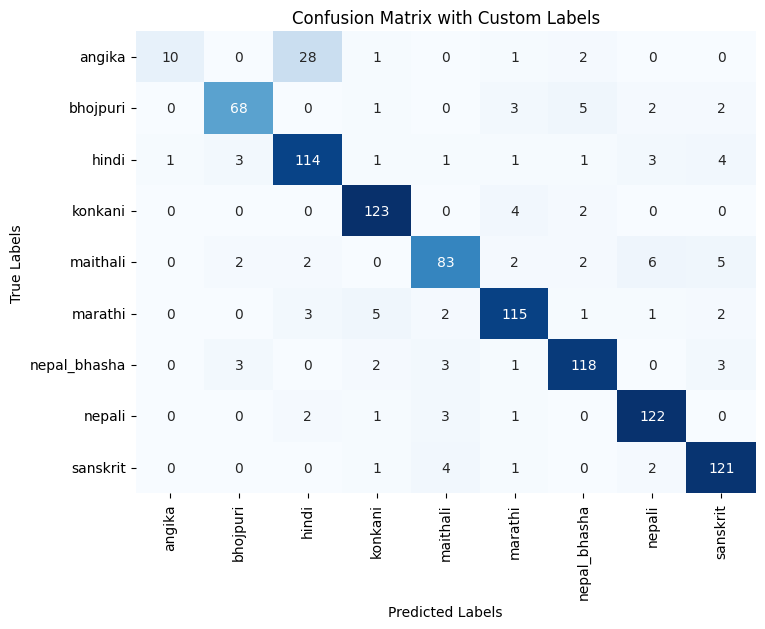

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example data

# Define custom class labels
class_labels = ['angika', 'bhojpuri', 'hindi', 'konkani', 'maithali', 'marathi', 'nepal_bhasha', 'nepali', 'sanskrit']

# Create confusion matrix with custom labels
cm = confusion_matrix(df_test['class'].values, y_pred, labels=np.arange(len(class_labels)))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Custom Labels')
plt.show()


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Accuracy
accuracy = accuracy_score(df_test['class'].values, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Precision, Recall, F1-Score
precision = precision_score(df_test['class'].values, y_pred, average='weighted')
recall = recall_score(df_test['class'].values, y_pred, average='weighted')
f1 = f1_score(df_test['class'].values, y_pred, average='weighted')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

# Classification Report
print('******')
print(classification_report(df_test['class'].values, y_pred))


Accuracy: 0.8740
Precision: 0.8768, Recall: 0.8740, F1-Score: 0.8662
******
              precision    recall  f1-score   support

           0       0.91      0.24      0.38        42
           1       0.89      0.84      0.87        81
           2       0.77      0.88      0.82       129
           3       0.91      0.95      0.93       129
           4       0.86      0.81      0.84       102
           5       0.89      0.89      0.89       129
           6       0.90      0.91      0.90       130
           7       0.90      0.95      0.92       129
           8       0.88      0.94      0.91       129

    accuracy                           0.87      1000
   macro avg       0.88      0.82      0.83      1000
weighted avg       0.88      0.87      0.87      1000



In [12]:
from sklearn.metrics import precision_recall_fscore_support

# Class-wise metrics
precision, recall, f1, _ = precision_recall_fscore_support(df_test['class'].values, y_pred, average=None)
class_labels = [f'Class {i}' for i in range(len(precision))]

# Create a DataFrame or plot directly
class_metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1-Score': f1}, index=class_labels)
print(class_metrics_df)


         Precision    Recall  F1-Score
Class 0   0.909091  0.238095  0.377358
Class 1   0.894737  0.839506  0.866242
Class 2   0.765101  0.883721  0.820144
Class 3   0.911111  0.953488  0.931818
Class 4   0.864583  0.813725  0.838384
Class 5   0.891473  0.891473  0.891473
Class 6   0.900763  0.907692  0.904215
Class 7   0.897059  0.945736  0.920755
Class 8   0.883212  0.937984  0.909774
